    После трех  дней перебора разных параметров и видов сетей, не подглядывая в интрнет, решил остановться :) Все равно нет хорошегно результата  
    Для обучения использую свои личные фото

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from matplotlib import pyplot as plt
from __future__ import absolute_import, division, print_function, unicode_literals
import cv2 as cv
import tensorflow_hub as hub
from tensorflow_examples.models.pix2pix import pix2pix
# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import os
# For measuring the inference time.
import time
%matplotlib inline
import pandas as pd
# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


Загрузим и обработаем фото

In [2]:
patch = os.path.abspath('D:/train')
photolist = os.listdir(patch)
len(photolist)

234

Преобразуем фото

In [3]:
lst_images = []
for i in photolist:
    adr = os.path.join(patch,i)
    im= cv.imread(adr)
    im = cv.resize(im,(512,512),interpolation = cv.INTER_CUBIC ) 
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    im = im/255
    lst_images.append(im)

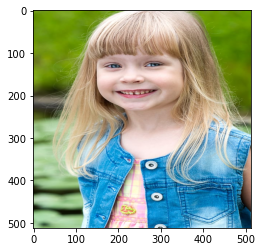

In [4]:
plt.imshow(lst_images[8])

создадим датасет

In [5]:
batch_size = 2
all_digits= np.array(lst_images).astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=512).batch(batch_size).prefetch(16)

## Строим discriminator

размер карты 512*512 

In [6]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(512, 512, 3)),
        layers.Conv2D(64, (4, 4), strides=(1, 1), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size = 6,strides =2,padding="same") , #256    
        layers.Conv2D(128, (4, 4), strides=(1, 1), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size = 5,strides =2,padding="same") ,#128
        layers.Conv2D(256, (4, 4), strides=(1, 1), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size = 4,strides =2,padding="same") , #64
        layers.Conv2D(512, (3, 3), strides=(1, 1), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size = 2,strides =2,padding="same") , #32
        layers.Conv2D(1024, (2, 2), strides=(1, 1), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size = 2,strides =2,padding="same") ,#16
        layers.Conv2D(1024, (2, 2), strides=(2, 2), padding="same"),#8
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        layers.GlobalMaxPooling2D(),
        layers.Dense(1024,activation='relu'),
        layers.Dense(512,activation='relu'),
        layers.Dense(256,activation='relu'),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 64)      3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 512, 64)      256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512, 512, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 128)     131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 128)     512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 256, 128)   

## Строим generator

In [7]:
latent_dim = 1024

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 8x8x1024 map
        layers.Dense(8 * 8 * latent_dim),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8 ,latent_dim)),
        layers.Conv2DTranspose(1024, (4, 4), strides=(2, 2), padding="same"),#16
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding="same"),#32
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),#64
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),#128
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"),#256
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding="same"),#512
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (4, 4), padding="same",activation='sigmoid')
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 65536)             67174400  
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 1024)      16778240  
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 1024)      4096      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 512)       83

## Класс со своим этапом обучения `train_step`

In [8]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали фейковое изображение с реальным изображением в тензор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки не реальных изображений
        misleading_labels = tf.ones((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

Определим модель

In [9]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00003,beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00003,beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy( from_logits=True),
)

In [13]:
# Обучим модель

epochs = 100
gan.fit(dataset, epochs=epochs)

Epoch 1/100
117/117 [==============================] - 64s 550ms/step - d_loss: 0.2312 - g_loss: 2.1495
Epoch 2/100
117/117 [==============================] - 65s 552ms/step - d_loss: 0.0786 - g_loss: 3.1548
Epoch 3/100
117/117 [==============================] - 65s 551ms/step - d_loss: 0.1974 - g_loss: 2.4568
Epoch 4/100
117/117 [==============================] - 65s 551ms/step - d_loss: 0.3561 - g_loss: 1.6037
Epoch 5/100
117/117 [==============================] - 65s 551ms/step - d_loss: 0.3002 - g_loss: 1.8814
Epoch 6/100
117/117 [==============================] - 65s 551ms/step - d_loss: 0.2016 - g_loss: 4.6682
Epoch 7/100
117/117 [==============================] - 65s 551ms/step - d_loss: 0.2981 - g_loss: 2.0783
Epoch 8/100
117/117 [==============================] - 65s 551ms/step - d_loss: 0.3205 - g_loss: 2.1639
Epoch 9/100
117/117 [==============================] - 65s 552ms/step - d_loss: 0.1323 - g_loss: 2.6324
Epoch 10/100
117/117 [==============================] - 65s 552m

117/117 [==============================] - 66s 561ms/step - d_loss: 0.3672 - g_loss: 1.6021
Epoch 80/100
117/117 [==============================] - 66s 563ms/step - d_loss: 0.2544 - g_loss: 2.3066
Epoch 81/100
117/117 [==============================] - 67s 573ms/step - d_loss: 0.1967 - g_loss: 2.4350
Epoch 82/100
117/117 [==============================] - 66s 565ms/step - d_loss: 0.4063 - g_loss: 2.7840
Epoch 83/100
117/117 [==============================] - 66s 565ms/step - d_loss: 0.3209 - g_loss: 1.7020
Epoch 84/100
117/117 [==============================] - 67s 570ms/step - d_loss: 0.2264 - g_loss: 2.4063
Epoch 85/100
117/117 [==============================] - 66s 565ms/step - d_loss: 0.1677 - g_loss: 3.2885
Epoch 86/100
117/117 [==============================] - 69s 585ms/step - d_loss: 0.9983 - g_loss: 2.5226
Epoch 87/100
117/117 [==============================] - 69s 587ms/step - d_loss: 0.2279 - g_loss: 1.9557
Epoch 88/100
117/117 [==============================] - 67s 570ms/st

## Посмотрим результаты

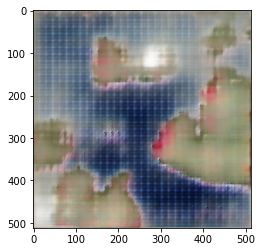

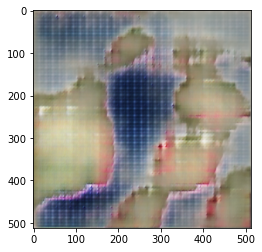

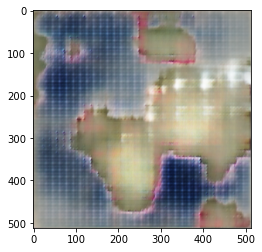

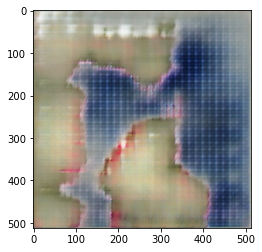

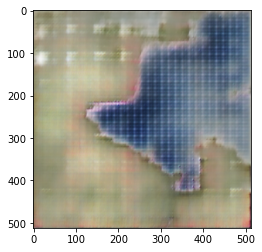

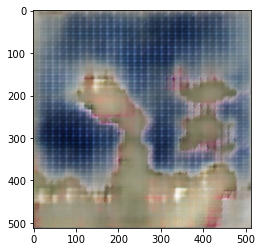

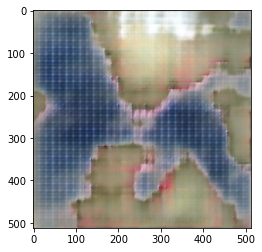

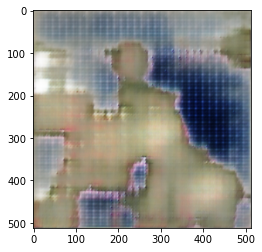

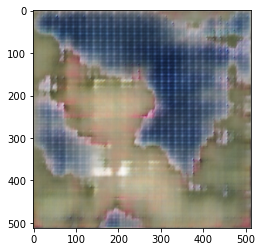

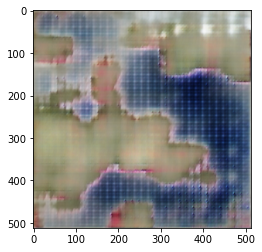

Что говорит дискриминатор на настоящие изображения
[[ 9.615485 ]
 [ 6.3033857]
 [14.43693  ]
 [11.345962 ]
 [46.779434 ]
 [12.7446575]
 [18.773062 ]
 [41.466084 ]
 [12.945369 ]
 [ 7.4541106]]
Что говорит дискриминатор на фейковые  изображения
[[-3.563498 ]
 [-1.4758362]
 [-3.0068917]
 [-2.267978 ]
 [-3.4544277]
 [-1.1270232]
 [-3.2182665]
 [-2.893124 ]
 [-1.7602346]
 [-4.1338916]]


In [15]:
num = 10
a = np.random.randint(0,234,(num))
z = []
for _ in range(num):   
    n = np.random.randn(latent_dim)
    n = n.reshape(1,latent_dim)
    p = generator.predict(n)
    p= p.reshape((512,512,3))
    z.append(p)
    plt.imshow(p)
    plt.show()
z= np.array(z)
print('Что говорит дискриминатор на настоящие изображения')
print(discriminator.predict(all_digits[a]))
print('Что говорит дискриминатор на фейковые  изображения')
print(discriminator.predict(z))
    

Используем в качетсве генератора pix2pix

In [7]:
all_digits_1 = all_digits *255
all_digits_1 = all_digits_1/127.5 -1

In [8]:
batch_size = 2

dataset_1 = tf.data.Dataset.from_tensor_slices(all_digits_1)
dataset_1 = dataset_1.shuffle(buffer_size=512).batch(batch_size).prefetch(16)

In [11]:
generator_g = pix2pix.unet_generator(3, norm_type='instancenorm')


In [12]:
class GAN_pix2pix(keras.Model):
    def __init__(self, discriminator, generator):
        super(GAN_pix2pix, self).__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN_pix2pix, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]


        # Строим по нему фейковое изображение
        generated_images = self.generator(real_images)
        if isinstance(generated_images, tuple):
            real_images = real_images[0]

        # собрали фейковое изображение с реальным изображением в тензор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # собрали метки не реальных изображений
        misleading_labels = tf.ones((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(real_images))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [13]:
gan_pix2pix = GAN_pix2pix(discriminator=discriminator, generator=generator_g)
gan_pix2pix.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy( from_logits=True),
)

In [14]:
epochs = 100
gan_pix2pix.fit(dataset_1, epochs=epochs)

Epoch 1/100
117/117 [==============================] - 88s 656ms/step - d_loss: 0.7877 - g_loss: 0.8479
Epoch 2/100
117/117 [==============================] - 75s 643ms/step - d_loss: 0.6927 - g_loss: 0.7655
Epoch 3/100
117/117 [==============================] - 76s 645ms/step - d_loss: 0.7170 - g_loss: 0.8870
Epoch 4/100
117/117 [==============================] - 76s 647ms/step - d_loss: 0.7037 - g_loss: 0.8529
Epoch 5/100
117/117 [==============================] - 76s 645ms/step - d_loss: 0.6962 - g_loss: 0.7658
Epoch 6/100
117/117 [==============================] - 76s 646ms/step - d_loss: 0.6847 - g_loss: 0.7289
Epoch 7/100
117/117 [==============================] - 76s 646ms/step - d_loss: 0.6784 - g_loss: 0.7575
Epoch 8/100
117/117 [==============================] - 76s 646ms/step - d_loss: 0.6969 - g_loss: 0.7034
Epoch 9/100
117/117 [==============================] - 76s 646ms/step - d_loss: 0.6872 - g_loss: 0.7277
Epoch 10/100
117/117 [==============================] - 76s 647m

117/117 [==============================] - 75s 640ms/step - d_loss: 0.6769 - g_loss: 0.7185
Epoch 80/100
117/117 [==============================] - 75s 640ms/step - d_loss: 0.7623 - g_loss: 0.7512
Epoch 81/100
117/117 [==============================] - 75s 640ms/step - d_loss: 0.6755 - g_loss: 0.7287
Epoch 82/100
117/117 [==============================] - 75s 640ms/step - d_loss: 0.6717 - g_loss: 0.7194
Epoch 83/100
117/117 [==============================] - 75s 640ms/step - d_loss: 0.6822 - g_loss: 0.6934
Epoch 84/100
117/117 [==============================] - 75s 640ms/step - d_loss: 0.6920 - g_loss: 0.7091
Epoch 85/100
117/117 [==============================] - 75s 640ms/step - d_loss: 0.7054 - g_loss: 0.6777
Epoch 86/100
117/117 [==============================] - 75s 640ms/step - d_loss: 0.6829 - g_loss: 0.6716
Epoch 87/100
117/117 [==============================] - 75s 640ms/step - d_loss: 0.6911 - g_loss: 0.7003
Epoch 88/100
117/117 [==============================] - 75s 640ms/st

Посмотрим результаты

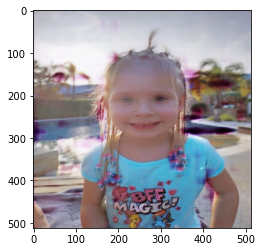

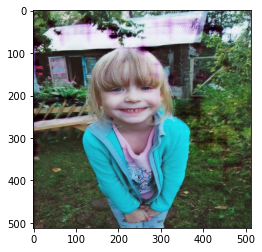

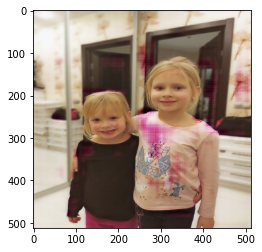

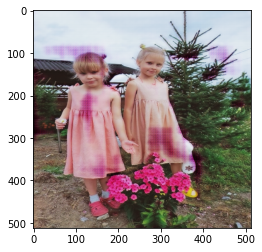

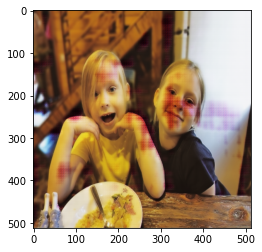

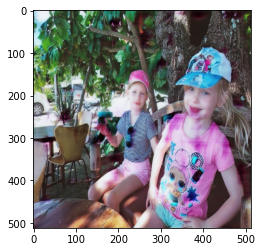

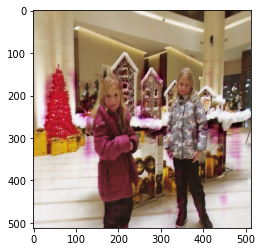

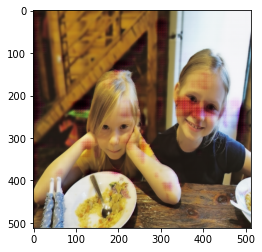

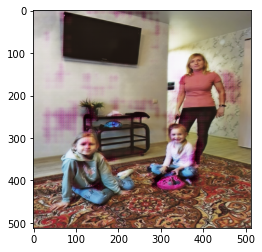

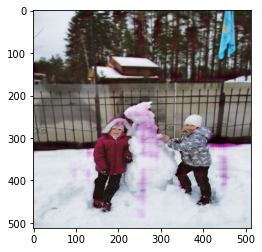

Что говорит дискриминатор на настоящие изображения
[[ 0.200335  ]
 [-0.19188112]
 [-0.23978406]
 [ 0.00673551]
 [-0.20935181]
 [ 0.13076892]
 [-0.1771352 ]
 [-0.22152057]
 [ 0.18134409]
 [ 0.22828263]]
Что говорит дискриминатор на фейковые  изображения
[[-0.3447259 ]
 [-0.16440055]
 [-0.53209853]
 [-0.4819786 ]
 [-0.350281  ]
 [-0.545385  ]
 [-0.78411794]
 [-0.5203941 ]
 [-0.36288428]
 [-0.3835056 ]]


In [20]:
num = 10
a = np.random.randint(0,234,(num))

p = generator_g.predict(all_digits_1[a])
for i in p:
    plt.imshow((i+1)/2)
    plt.show()


print('Что говорит дискриминатор на настоящие изображения')
print(discriminator.predict(all_digits_1[a]))
print('Что говорит дискриминатор на фейковые  изображения')
print(discriminator.predict(p))

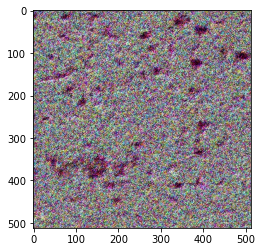

In [23]:
n = np.random.randn(512*512*3)
n = n.reshape(1,512,512,3)
a=generator_g.predict(n)[0]
plt.imshow((a+1)/2)
plt.show()


In [9]:
generator_x = pix2pix.unet_generator(3, norm_type='instancenorm')

In [10]:
class GAN_2(keras.Model):
    def __init__(self, discriminator, generator):
        super(GAN_2, self).__init__()
        self.discriminator = discriminator
        self.generator = generator


    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN_2, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, 512,512,3))

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали фейковое изображение с реальным изображением в тензор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, 512,512,3))

        # собрали метки не реальных изображений
        misleading_labels = tf.ones((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [11]:
gan_2 = GAN_2(discriminator=discriminator, generator=generator_x)
gan_2.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy( from_logits=True),
)

In [17]:
epochs = 50
gan_2.fit(dataset_1, epochs=epochs)

Epoch 1/50
117/117 [==============================] - 76s 644ms/step - d_loss: 73.6733 - g_loss: 108.9740
Epoch 2/50
117/117 [==============================] - 76s 645ms/step - d_loss: 56.0303 - g_loss: 133.3912
Epoch 3/50
117/117 [==============================] - 76s 646ms/step - d_loss: 69.4023 - g_loss: 158.5784
Epoch 4/50
117/117 [==============================] - 76s 648ms/step - d_loss: -17.6718 - g_loss: 115.8056
Epoch 5/50
117/117 [==============================] - 76s 648ms/step - d_loss: -217.4240 - g_loss: 160.7007
Epoch 6/50
117/117 [==============================] - 76s 649ms/step - d_loss: 7.0450 - g_loss: 26.4838
Epoch 7/50
117/117 [==============================] - 76s 649ms/step - d_loss: -15.4946 - g_loss: 41.2633
Epoch 8/50
117/117 [==============================] - 76s 648ms/step - d_loss: -133.3667 - g_loss: 47.0400
Epoch 9/50
117/117 [==============================] - 76s 649ms/step - d_loss: -59.3642 - g_loss: 147.4954
Epoch 10/50
117/117 [======================

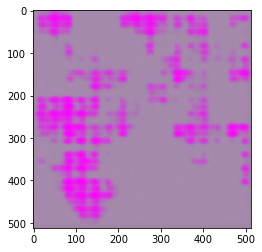

In [26]:
random_latent_vectors = tf.random.normal(shape=(1, 512,512,3))
# n = np.random.randn(512*512*3)
# n = n.reshape(1,512,512,3)
# a=generator_x.predict(n)[0]
a=generator_x.predict(random_latent_vectors)[0]
plt.imshow((a+1)/2)
plt.show()


Хотел еще порешать задачу с  сигналами от телефона, но к сожадлению уже не успеваю. ПО новому курсу уже второй урок идет